# 비화재보 분류 


---
## 1. 데이터 전처리     
---

### 각 년도별 데이터 결합 

In [1]:
import pandas as pd
import numpy as np 
import re
import pickle
import xlrd
import  matplotlib.pyplot as plt
from konlpy.tag import Okt 
okt = Okt()

start_year= 2016
end_year =2021

In [ ]:
df_all =pd.DataFrame()
#년도합치기
for year in range(start_year,end_year+1):
#시트 이름 가져오기    
    wb = xlrd.open_workbook(f"{year}년 전체 신고건수_관할 및 재난주소 추가.xls")
    globals()[f'df_{year}']=pd.DataFrame()
#Sheet 합치기
    for  i in range(len(wb.sheets())):
        tmp = pd.read_excel(f"{year}년 전체 신고건수_관할 및 재난주소 추가.xls",sheet_name = wb.sheet_names()[i])['신고내용'].dropna(axis=0).T
        globals()[f'df_{year}']= pd.concat([globals()[f'df_{year}'],tmp], axis = 0)
    df_all= pd.concat([df_all,globals()[f'df_{year}']], axis = 0)

##### 임시저장

In [2]:
# with open(f"119_신고내용_{start_year} - {end_year}.pickle","wb") as fw:
#     pickle.dump(df_all, fw)   
with open(f"119_신고내용_{start_year} - {end_year}.pickle",'rb') as fr:
    df_all = pickle.load(fr)

### 중복 문자열 제거

In [3]:
print(len(df_all))
df_all= pd.DataFrame(set(df_all[0]))
print(len(df_all))
print(df_all.head(3))

1711724
1368100
                                  0
0  [의식 있음] 내당홈플러스 3층 꽃집 앞 / 여성 쓰러짐 
1        동구시장 풀과 나무 한의원//호흡곤란 사지 마비
2                ★★주간 기동순찰 및 훈련출동★★


###  신고내용 전처리 

In [84]:
from konlpy.tag import Okt 
okt = Okt()
print(okt.pos('속보기'))  #속보기 한 단어로 인식 X   -> AAA로 임시 치환
print(okt.pos('오작동')) # 오+작동으로 분리된 후 오가 제거되어 의미가 왜곡 -> BBB로 임시 치환
# 문제X
print(okt.pos('경보기'),okt.pos('경보'),okt.pos('속보')) 

[('속', 'Modifier'), ('보기', 'Noun')]
[('오', 'Modifier'), ('작동', 'Noun')]
[('있다', 'Adjective')]
[('경보기', 'Noun')] [('경보', 'Noun')] [('속보', 'Noun')]


In [43]:
df_all2 = df_all.copy()
for i in range(len(df_all2)):
    tmp = re.sub(r'[^가-힣+ ]',' ',df_all2.iloc[i,0]) # 한글말고 제거
    tmp = re.sub('속보기','AAA',tmp) # 속보기 ->A로 단어 치환    
    tmp = re.sub('오작동','BBB',tmp) # 오작동 ->B로 단어 치환    
    df_all2.iloc[i,0] = tmp
df_all2.iloc[702307 ,0]=re.sub('속보기','속보', df_all2.iloc[702307 ,0]) # 알수없는 이유로 치환이 안됨
print(df_all2.head(3))
print(len(df_all2))

                                            0
1                       문의 아이 아픔 아침 내원 가능 병원 
2   추가 라일락 아파트        호    갑자기 쓰러진후 몸을 떨고 있다 
3                       문의 아이 아픔 아침 내원 가능 병원 
1711724


In [44]:
#속보기 단어 제거 확인
print(f'속보기 단어 변경 전   : {df_all[0].apply(lambda x: re.search("속보기", x)is not None).sum()}')
print(f'속보기 단어 변경 후 :{df_all2[0].apply(lambda x: re.search("속보기", x)is not None).sum()}')
print(f'AAA 단어 변경 후 :{df_all2[0].apply(lambda x: re.search("AAA", x)is not None).sum()}')
print(f'속보기 단어 변경 전   : {df_all[0].apply(lambda x: re.search("오작동", x)is not None).sum()}')
print(f'오작동 단어 변경 후 :{df_all2[0].apply(lambda x: re.search("오작동", x)is not None).sum()}')
print(f'BBB 단어 변경 후 :{df_all2[0].apply(lambda x: re.search("BBB", x)is not None).sum()}')
# print(f'제거 안된 문장 :{df_all2[0][df_all2[0].apply(lambda x: re.search("속보기", x)is not None)]}')

속보기 단어 변경 전   : 8995
속보기 단어 변경 후 :0
AAA 단어 변경 후 :8995
속보기 단어 변경 전   : 11051
오작동 단어 변경 후 :0
BBB 단어 변경 후 :11051


###  문장 -> 형태소 형태로 변환
형태소 분석(Noun, Adjective) -명사와 형용사만  
1 글자를 배제  -의미가 거의X  
불용어 제외  

In [100]:

sents = []
for i in range(len(df_all2[0])):
    print("\r[tokenizing]  {}  /  {}   {}  %".format(i+1, len(df_all2[0]), round( (i / len(df_all2[0])) * 100 , 1 ) ), end = '    ', flush = False)
    pos_res = okt.pos(df_all2[0].iloc[i])
    
    STOP_WORDS = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
    keywords = []
    for word, pos in pos_res:
        if ((pos == "Noun")|(pos == "Adjective")| (pos =='Alpha'))&(len(word) >= 2)&(word not in STOP_WORDS):
            word = word.replace('AAA', '속보기')
            word = word.replace('BBB','오작동') # 원래 단어로 되돌리기
            keywords.append(word)
    sents.append(' '.join(keywords))
# print(sents[0:5])

[tokenizing]  1711724  /  1711724   100.0  %                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [3]:
# with open(f"119전처리_{start_year}-{end_year}.pickle","wb") as fw:
#     pickle.dump(sents, fw)   
with open(f"119전처리_{start_year}-{end_year}.pickle",'rb') as fr:
    sents = pickle.load(fr)

###  전처리 전후 키워드 갯수 확인
비화재보 주요 키워드 : 경보, 속보  
비화재보 제외 키워드 : 테스트, 오인주의, 훈련, 점검   

#### 경보, 속보  

In [101]:
check = []
for i in range(len(sents)) :
    if '속보' in sents[i]:
            check.append(sents[i])
print(f'기존 [속보] 단어 수: {df_all2[0].apply(lambda x: re.search("속보", x)is not None).sum()}')
print(f'전처리 후 [속보] 단어 수: {len(check)}\n')  
check = []
for i in range(len(sents)) :
    if '경보' in sents[i]:
            check.append(sents[i])
print(f'기존 [경보] 단어 수: {df_all2[0].apply(lambda x: re.search("경보", x)is not None).sum()}')
print(f'전처리 후 [경보] 단어 수: {len(check)}\n')  

기존 [속보] 단어 수: 9217
전처리 후 [속보] 단어 수: 18038

기존 [경보] 단어 수: 16910
전처리 후 [경보] 단어 수: 16792



#### 테스트, 오인주의, 훈련, 점검   

In [102]:
check = []
for i in range(len(sents)) :
    if '점검' in sents[i]:
            check.append(sents[i])
print(f'기존 [점검] 단어 수: {df_all2[0].apply(lambda x: re.search("점검", x)is not None).sum()}')
print(f'전처리 후 [점검] 단어 수: {len(check)}\n')  
# df_all2[df_all2[0].apply(lambda x: re.search("점검", x)is not None)]
check = []
for i in range(len(sents)) :
    if '훈련' in sents[i]:
            check.append(sents[i])
print(f'기존 [훈련] 단어 수: {df_all2[0].apply(lambda x: re.search("훈련", x)is not None).sum()}')
print(f'전처리 후 [훈련] 단어 수: {len(check)}\n')  
# df_all2[df_all2[0].apply(lambda x: re.search("훈련", x)is not None)]
check = []
for i in range(len(sents)) :
    if '오인' in sents[i]:
            check.append(sents[i])
print(f'기존 [오인] 단어 수: {df_all2[0].apply(lambda x: re.search("오인", x)is not None).sum()}')
print(f'전처리 후 [오인] 단어 수: {len(check)}\n')  
# df_all2[df_all2[0].apply(lambda x: re.search("오인", x)is not None)]
check = []
for i in range(len(sents)) :
    if '테스트' in sents[i]:
            check.append(sents[i])
print(f'기존 [테스트] 단어 수: {df_all2[0].apply(lambda x: re.search("테스트", x)is not None).sum()}')
print(f'전처리 후 [테스트] 단어 수: {len(check)}\n')  
# df_all2[df_all2[0].apply(lambda x: re.search("테스트", x)is not None)]


기존 [점검] 단어 수: 2433
전처리 후 [점검] 단어 수: 2431

기존 [훈련] 단어 수: 4373
전처리 후 [훈련] 단어 수: 4373

기존 [오인] 단어 수: 13180
전처리 후 [오인] 단어 수: 12967

기존 [테스트] 단어 수: 22230
전처리 후 [테스트] 단어 수: 22230



### 비화재보 /화재 데이터 분리

In [5]:
#화재보
df_sents = pd.DataFrame(sents)
non_fire=[]
fire=[]
for i in range(len(sents)):
    print("\r[비화재보 분류]  {}  /  {}   {}  %".format(i+1, len(sents), round( (i / len(sents)) * 100 , 1 ) ), end = '    ', flush = False)
    if (('경보' in df_sents.iloc[i,0])|('속보' in df_sents.iloc[i,0])) and (('점검' not in df_sents.iloc[i,0])&('훈련' not in df_sents.iloc[i,0])&('오인' not in df_sents.iloc[i,0])&('테스트' not in df_sents.iloc[i,0])):
        non_fire.append(df_sents.iloc[i,0])
    else :
        fire.append(df_sents.iloc[i,0]) 
print( f'\n비화재보 / 전체 데이터 : {len(non_fire)} / {len(sents)} \n비화재보 비율 : {round((len(non_fire)/ len(sents))*100,2)}%')        

[비화재보 분류]  1711724  /  1711724   100.0  %                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [10]:
df_non_fire=pd.DataFrame(non_fire)
print("비화재보 데이터 ")
print(f'[경보] 단어 수: {df_non_fire[0].apply(lambda x: re.search("경보", x)is not None).sum()}')
print(f'[속보] 단어 수: {df_non_fire[0].apply(lambda x: re.search("속보", x)is not None).sum()}')
print(f'[테스트] 단어 수: {df_non_fire[0].apply(lambda x: re.search("테스트", x)is not None).sum()}')
print(f'[훈련] 단어 수: {df_non_fire[0].apply(lambda x: re.search("훈련", x)is not None).sum()}')
print(f'[오인] 단어 수: {df_non_fire[0].apply(lambda x: re.search("오인", x)is not None).sum()}')
print(f'[점검] 단어 수: {df_non_fire[0].apply(lambda x: re.search("점검", x)is not None).sum()}')
# df_non_fire[df_non_fire[0].apply(lambda x: re.search("테스트", x)is not None)]

비화재보 데이터 
[경보] 단어 수: 16397
[속보] 단어 수: 10725
[테스트] 단어 수: 0
[훈련] 단어 수: 0
[오인] 단어 수: 0
[점검] 단어 수: 0


In [4]:
# with open(f"비화재보_{start_year}-{end_year}.pickle","wb") as fw:
#     pickle.dump(non_fire, fw)   
# with open(f"화재_{start_year}-{end_year}.pickle","wb") as fw:
#     pickle.dump(fire, fw)   
with open(f"비화재보_{start_year}-{end_year}.pickle",'rb') as fr:
    non_fire = pickle.load(fr)
        
with open(f"화재_{start_year}-{end_year}.pickle",'rb') as fr:
    fire = pickle.load(fr)    

In [34]:
# #함수만들어서 다음에 쓰기

# STOP_WORDS = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
# def make_tonken(df,STOP_WORDS):
#     for i in range(len(df)):
#         print("\r[tokenizing]  {}  /  {}   {}  %".format(i+1, len(df), round( (i / len(df)) * 100 , 1 ) ), end = '    ', flush = False)
#         text = re.sub(r'[^0-9a-zA-Zㄱ-ㅎ가-힣]',' ',df.iloc[i,0]) # 한글/숫자/영어
#         pos_res = okt.pos(text)
#         keywords = []
#         for word, pos in pos_res:
#             if ((pos == "Noun")|(pos == "Adjective")|(pos =='Alpha'))&(len(word) >= 2)&(word not in STOP_WORDS): # 단어형식제한 / 길이제한/ 불용어제한
#                 keywords.append(word)
#         sents.append(' '.join(keywords))    
#     # return sents
#     sentences = []
#     for sen in sents:
#         sentences.append(sen.split())
#     return sentences


---
## 2. 분석
---

In [41]:

import gensim
import pandas as pd
import os
import pickle
import re
# import pyLDAvis.gensim
from gensim import corpora
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
from wordcloud import WordCloud
import  matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
#from iteration_utilities import deepflatten  ## list flatten 
import random
from collections import Counter
import time
from datetime import datetime 
import matplotlib.font_manager
import networkx as nx
import matplotlib.font_manager as fm
import math
from sklearn.manifold import TSNE
from gensim.models import CoherenceModel

from gensim.utils import simple_preprocess

# from soynlp.tokenizer import LTokenizer
# from soynlp.noun import LRNounExtractor_v2

matplotlib.font_manager.findSystemFonts(fontpaths  = None , fontext = 'ttf') # 활용가능한 폰트 찾기 

def make_dtm(text, max_features = 1000000, min_df = 1, stopwords = None):
    while True:
        cv =  CountVectorizer(max_features= max_features, 
                              min_df = min_df, 
                              stop_words = stopwords,
                              tokenizer = lambda x: x.split(' '))
        tdm = cv.fit_transform(text)
        words = cv.get_feature_names()
                
        try:
            tdm_mat = tdm.toarray()
        except MemoryError:
            min_df += 10
            print("\rmin_freq:{}".format(min_df), end = " ")
        else:
            break

    tdm_df = pd.DataFrame(tdm_mat)
    tdm_df.columns= np.array(words)
    return tdm_df

def make_wordcloud(dtm_mat, width=1000, height=500, max_words = 500):
    dtm_mat_sum = dtm_mat.sum(axis = 0)
    wc_dic = {}
    for i in range(len(dtm_mat_sum)):
        wc_dic[dtm_mat_sum.index[i]] = int(dtm_mat_sum.iloc[i])
    wordcloud = WordCloud(font_path=r"C:\Windows\Fonts\malgun.ttf",
                          width = width, height = height,
                          background_color = "white",
                          max_words=max_words).generate_from_frequencies(wc_dic)    
    return wordcloud

def analy_asso(dtm_mat, support, confidence):
    asso_data = dtm_mat.apply(lambda x: np.where(x ==0, False, True), axis = 0)        
    while True:
        try:
            asso_gen = apriori(asso_data, min_support=support, use_colnames=True,
                                   max_len = 2, low_memory = True)
        except MemoryError:    
            support += 0.0001
            print("\rsupport:",support, end = " ")
        else:
            break
            
    asso_cut_confidence = association_rules(asso_gen, metric="confidence", min_threshold= confidence )
    return(asso_cut_confidence)

def make_network(asso_rules, font_size = 10, eps = .1, figure = True):
    sample_g = nx.Graph()
    for i in range(len(asso_rules)):
        sample_g.add_edge(" ".join(list(asso_rules["antecedents"][i])),
                              " ".join(list(asso_rules["consequents"][i])),
                              weight = asso_rules["support"].iloc[i])
            
    pgr_cen = nx.pagerank(sample_g) ## 페이지링크 알고리즘을 해당노드의 연결성(엣지 웨이트)
    sorted_pgr = sorted(pgr_cen.items(), key = (lambda x:x[1]), reverse = True)
        
    graphic_g = nx.Graph()

    for i in range(len(sorted_pgr)):
        graphic_g.add_node(sorted_pgr[i][0])
                            
    for j in range(len(asso_rules)):
        graphic_g.add_weighted_edges_from(
                    [ (" ".join(list(asso_rules["antecedents"][j])),
                       " ".join(list(asso_rules["consequents"][j])),
                       asso_rules["support"].iloc[j] * 100 )])
        
    weight_list = ["떡볶이"]
    node_weight = []
    for key, values in pgr_cen.items():
        if key in weight_list:
                node_weight.append(math.log(values * 50000 * 10000)* 500)
        else:
            node_weight.append(math.log(values * 50000)* 500)
    
    if figure:
        nx.draw(graphic_g, 
                node_color = 'white',
                nodelist = pgr_cen.keys(),
                node_size = node_weight,
                edge_color= "#2090e6", 
                pos = nx.spring_layout(graphic_g,k = eps), 
                font_size = font_size,
                font_family = 'NanumGothic',
                with_labels = True,
                font_weight = 'bold',
                alpha = 1,
                font_color = "black",
                edgecolors = "#2090e6",
                linewidths = 2)
    
    else:
        return sorted_pgr


### topic modeling -> LDA 

def compute_coherence_values(text, limit, start=2, step=3):
    
    text = [words.split(" ") for words in text]  
    dictionary = corpora.Dictionary(text)
    corpus = [dictionary.doc2bow(text) for text in text]
    coherence_values = []
    model_list = []
    perplexity_values = []
    for num_topics in range(start, limit, step):
        print("Topics: {}".format(num_topics))
        model = gensim.models.ldamodel.LdaModel(corpus, 
                                               id2word=dictionary, 
                                               num_topics = num_topics, 
                                               update_every = 1,
                                               #chunksize = round(len(corpus)/20),
                                               passes=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=text, dictionary=dictionary, coherence='c_v')        
        perplexitymodel = model.log_perplexity(corpus)
        
        coherence_values.append(coherencemodel.get_coherence())
        perplexity_values.append(perplexitymodel)
        
    return model_list, coherence_values, perplexity_values

def run_lda(text, num_topics):
    """
    text: 문장
    num_topics: 도출할 토픽의 수
    num_words: 토픽당 출력할 단어의 수(시각화용)
    """
    text = [words.split(" ") for words in text]  
    dictionary = corpora.Dictionary(text)
    corpus = [dictionary.doc2bow(text) for text in text]

    ldamodel = gensim.models.ldamodel.LdaModel(corpus, 
                                               id2word=dictionary, 
                                               num_topics = num_topics, 
                                               update_every = 1,
                                               #chunksize = round(len(corpus)/20),
                                               passes=10)
    return corpus, ldamodel,id2word
#반환값 dictionary 추가함

def find_topic_terms(lda_model, topicn, topn = 20):
    term_dic = {}
    for idx, term in lda_model.id2word.iteritems():
        term_dic[idx]= term
        
    topic_terms = lda_model.get_topic_terms(topicn, topn = topn)
    all_terms = []
    all_prob = []
    for term_prob in topic_terms:
        term = term_dic[term_prob[0]]
        prob = term_prob[1]
        all_terms.append(term)
        all_prob.append(prob)
        
    return(pd.DataFrame({"{}_term".format(topicn) : all_terms,
                "{}_prob".format(topicn) : all_prob}))
     
  
def find_doc_topic(model, corpus):
    '''
    model : 토픽 모델
    corpus : 모델 생성시 활용된 corpus, doc2bow 함수를 통해 성성된 결과물임
    '''
    
    all_assigned_topic = []
    all_assigned_prob = []
    for cor in corpus :
        topic_list = model.get_document_topics(cor, minimum_probability = 0)
        sorted_topic_list = sorted(topic_list, key=lambda x:x[1], reverse=True)
        all_assigned_topic.append(sorted_topic_list[0][0])
        all_assigned_prob.append(sorted_topic_list[0][1])
        
    return pd.DataFrame({"topic" : all_assigned_topic, "prob" : all_assigned_prob})


def remove_stopwords(texts, stopwords):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]

### 텍스트 마이닝 & 연관어 분석

C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


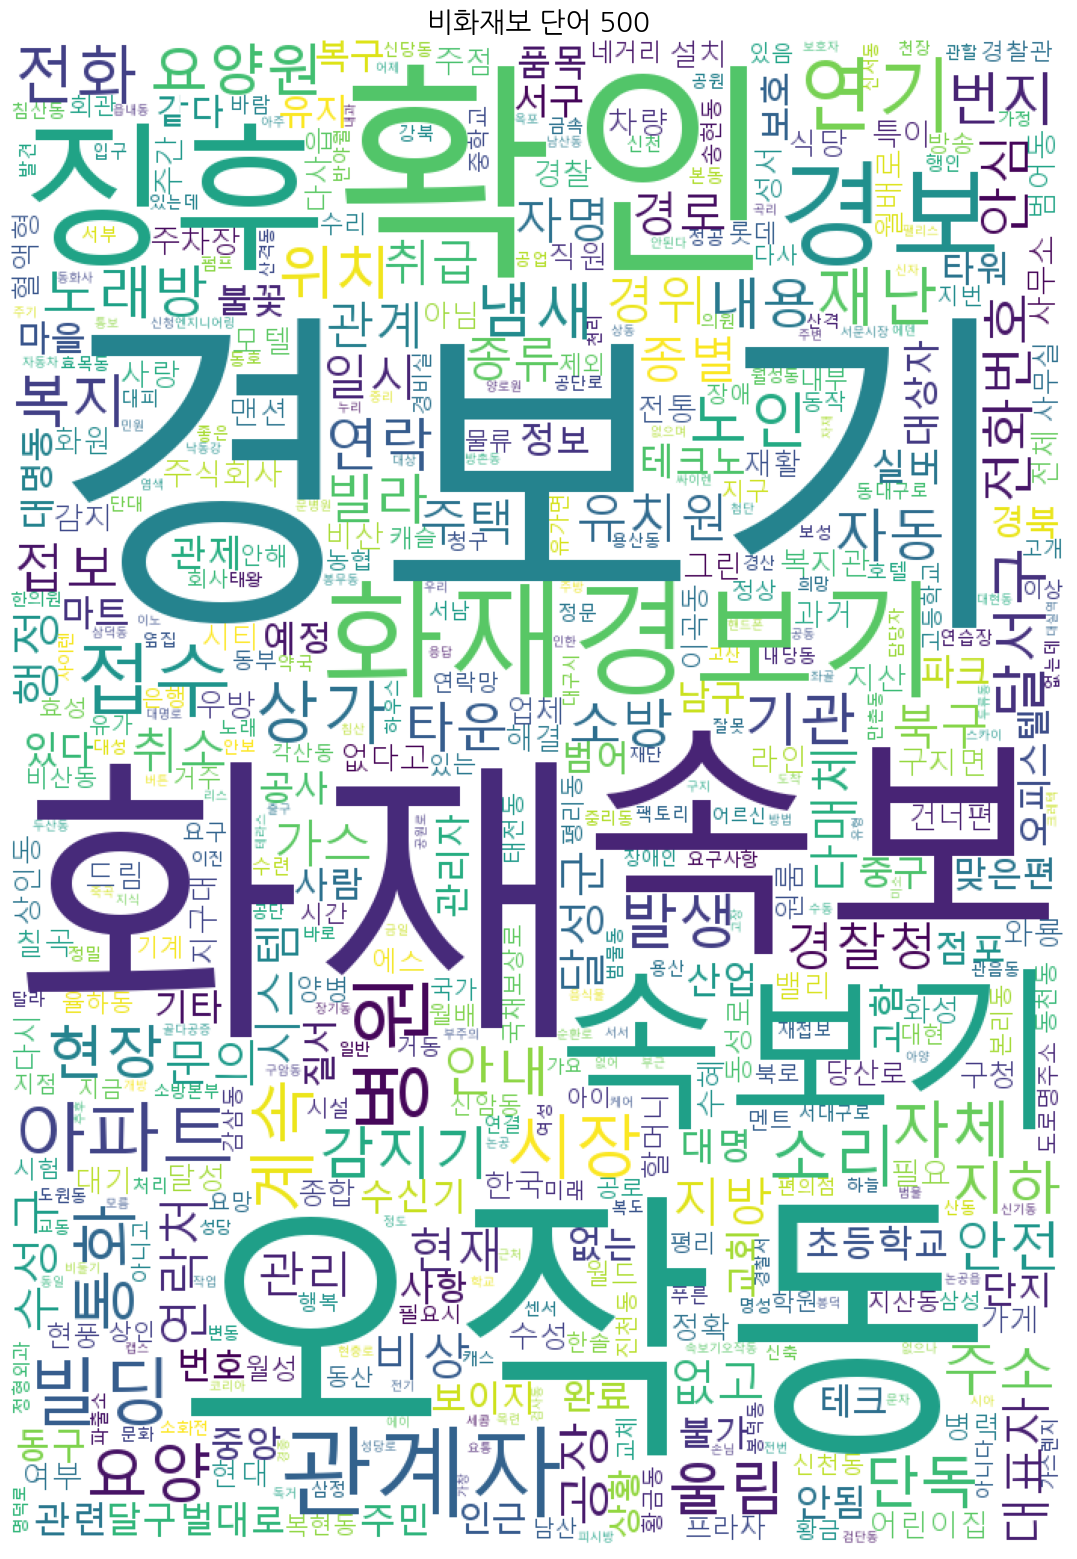

In [6]:
word_freq = []
word_pgr = []
doc_cnt = len(non_fire)
dtm_mat = make_dtm(non_fire, stopwords = ['경보기','화재','속보','경보기','속보기','오작동','관련',
    '번지','경찰관','설치','추가','작동','설비','건물','없음','신고','출동','린다','요청','센터','없다','있음','없는','대구광역시','추정',
    '대구','조치','상태','확인','관계자','전화'])
plt.figure( figsize = (20, 20),dpi=100 )
plt.rc('font', family='NanumGothic')
plt.imshow(make_wordcloud(dtm_mat, width = 700, height = 1000))
plt.axis("off")
# plt.savefig(main_path + "/results/{}/{}_wordcloud.png".format(f_name ,year), bbox_inches='tight')
plt.title("비화재보 단어 500",fontsize=20)
plt.show()
plt.close()

In [7]:
word1 =dtm_mat.sum().sort_values(ascending=False)
word1.head(100)

경보기    11655
화재      9030
오작동     7950
속보      6101
확인      5367
       ...  
번호       261
없는       259
수신기      255
관련       250
실버       244
Length: 100, dtype: int64

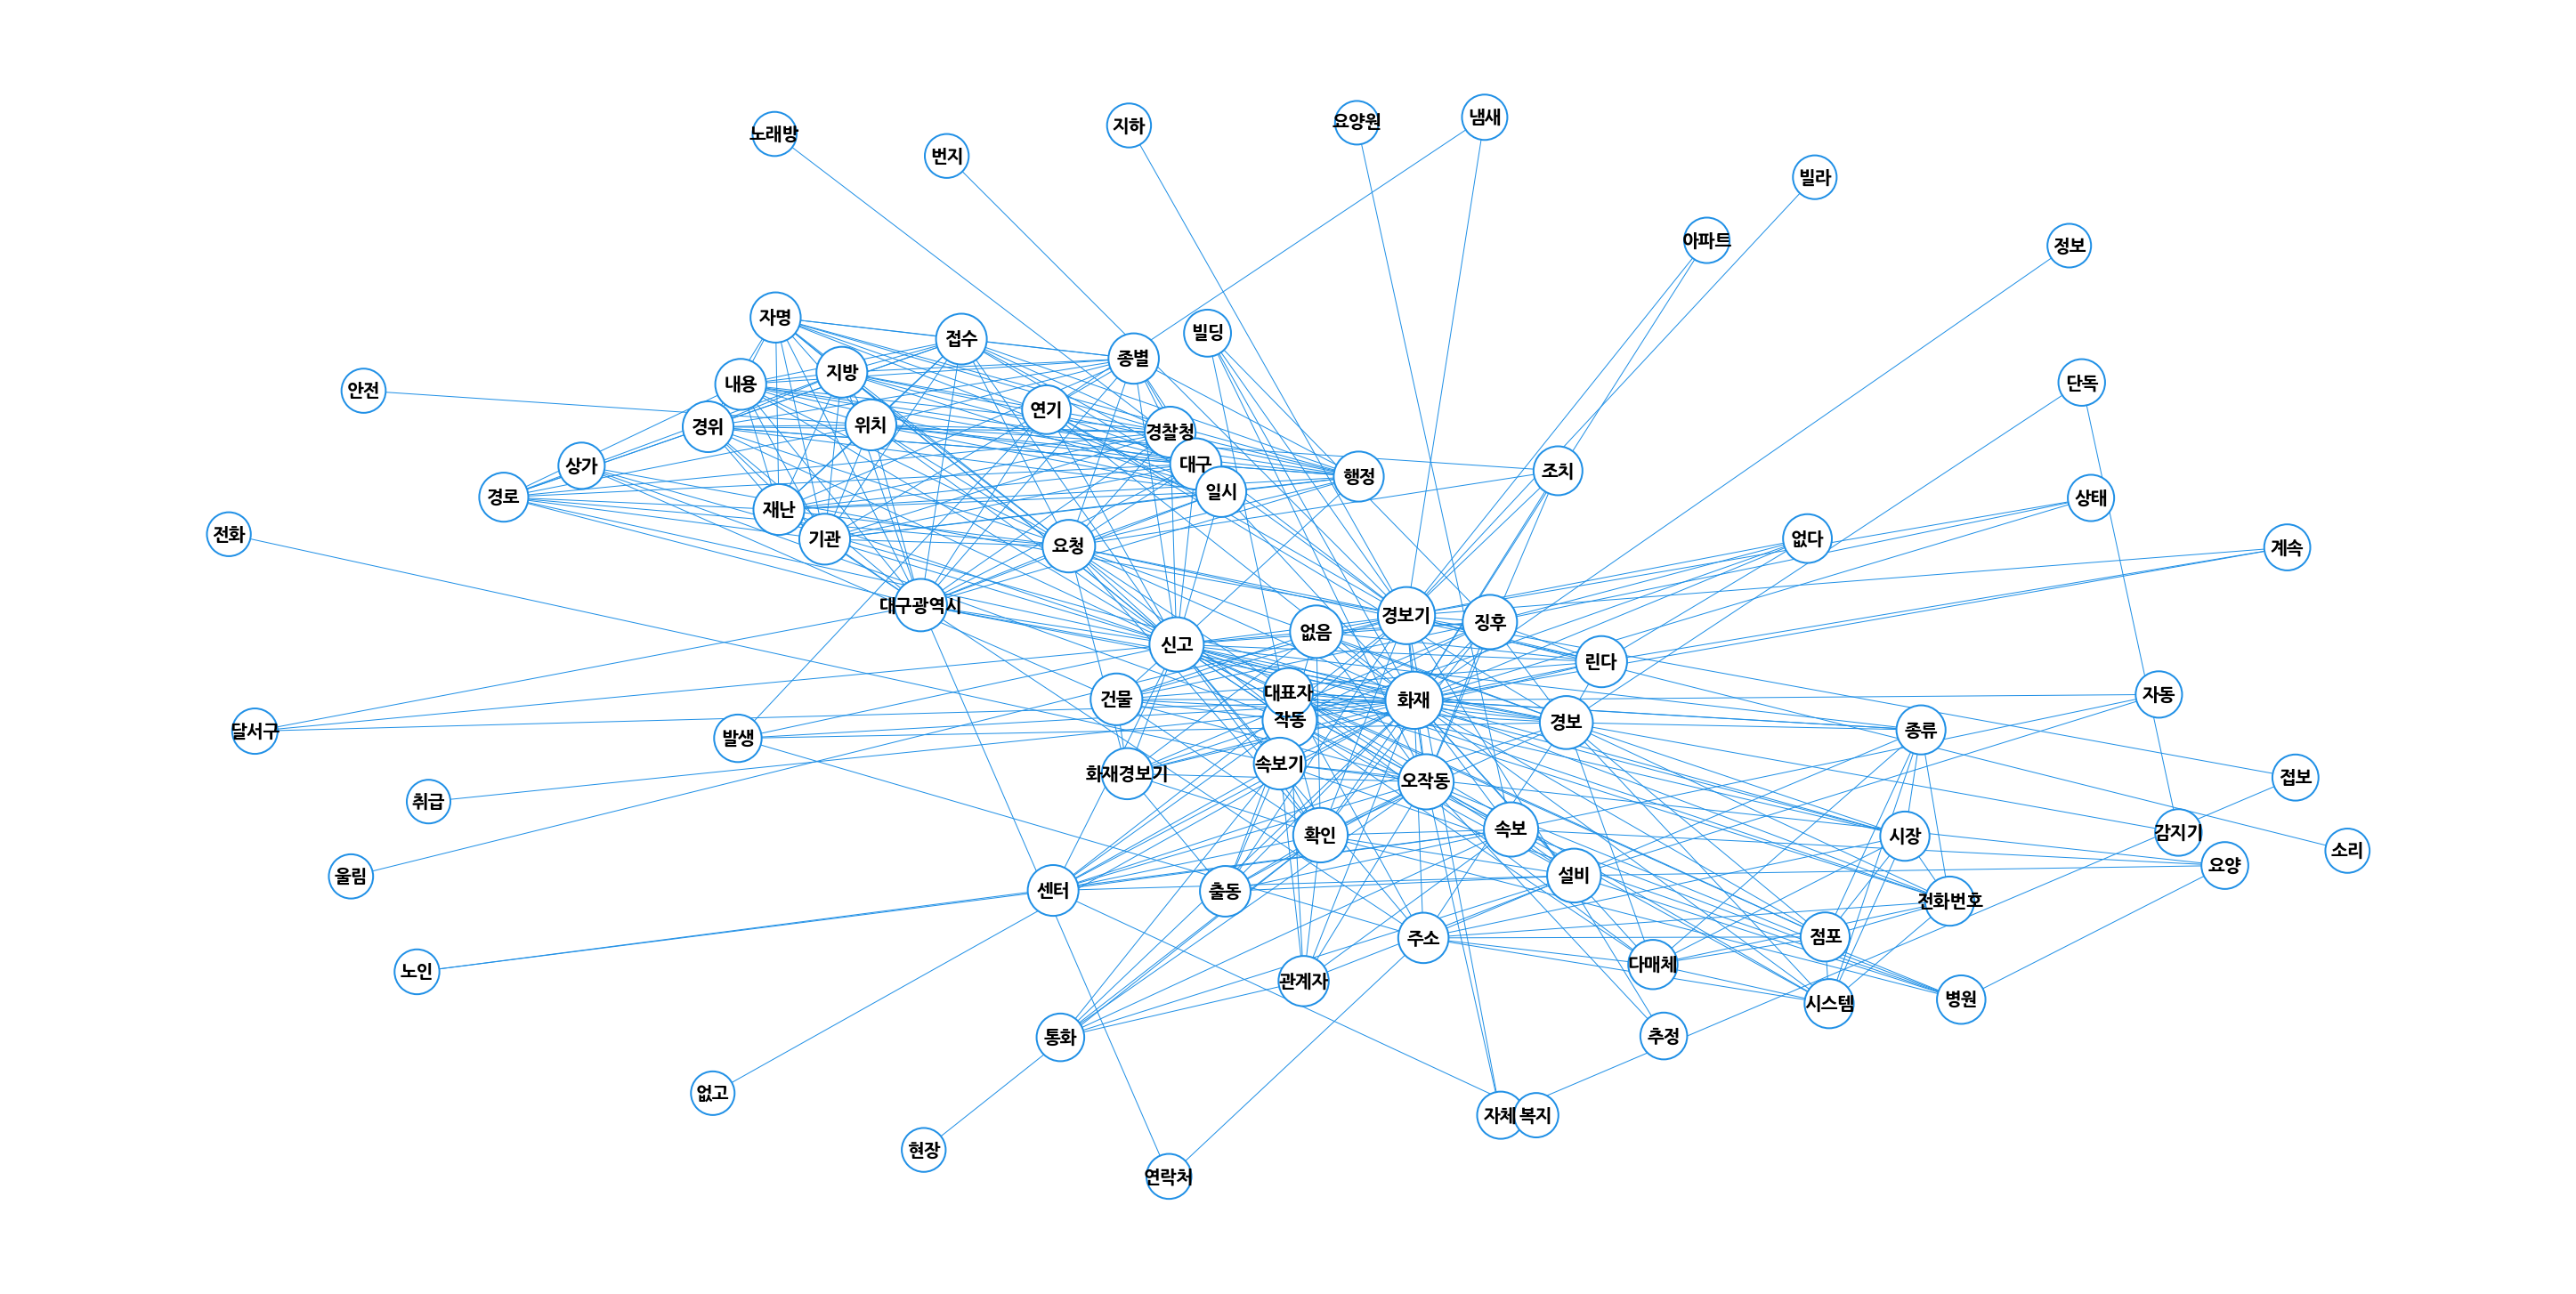

In [22]:
### 단어빈도 및 네트워크 분석 ###
word_freq = []
word_pgr = []

doc_cnt = len(non_fire)
dtm_mat = make_dtm(non_fire, stopwords = ["추가","아아"])
word_divide_doc = pd.DataFrame(pd.Series(dtm_mat.sum(axis = 0), name = "freq"))
word_divide_doc['idf'] = pd.Series(dtm_mat.sum(axis = 0), name = "freq") / doc_cnt
word_freq.append(word_divide_doc)
asso_rules = analy_asso(dtm_mat, support= 0.01, confidence = 0.1)
asso_rules.to_csv('asso_rules_nonfire.csv', encoding ='cp949')
plt.figure( figsize = (40, 20) )
make_network(asso_rules, font_size = 20,eps = 1, figure = True)
plt.axis("off")
plt.show()
# plt.savefig(main_path + "/results/{}/{}_wordnetwork.png".format(f_name, year), bbox_inches = "tight")
plt.close()

min_freq:21 

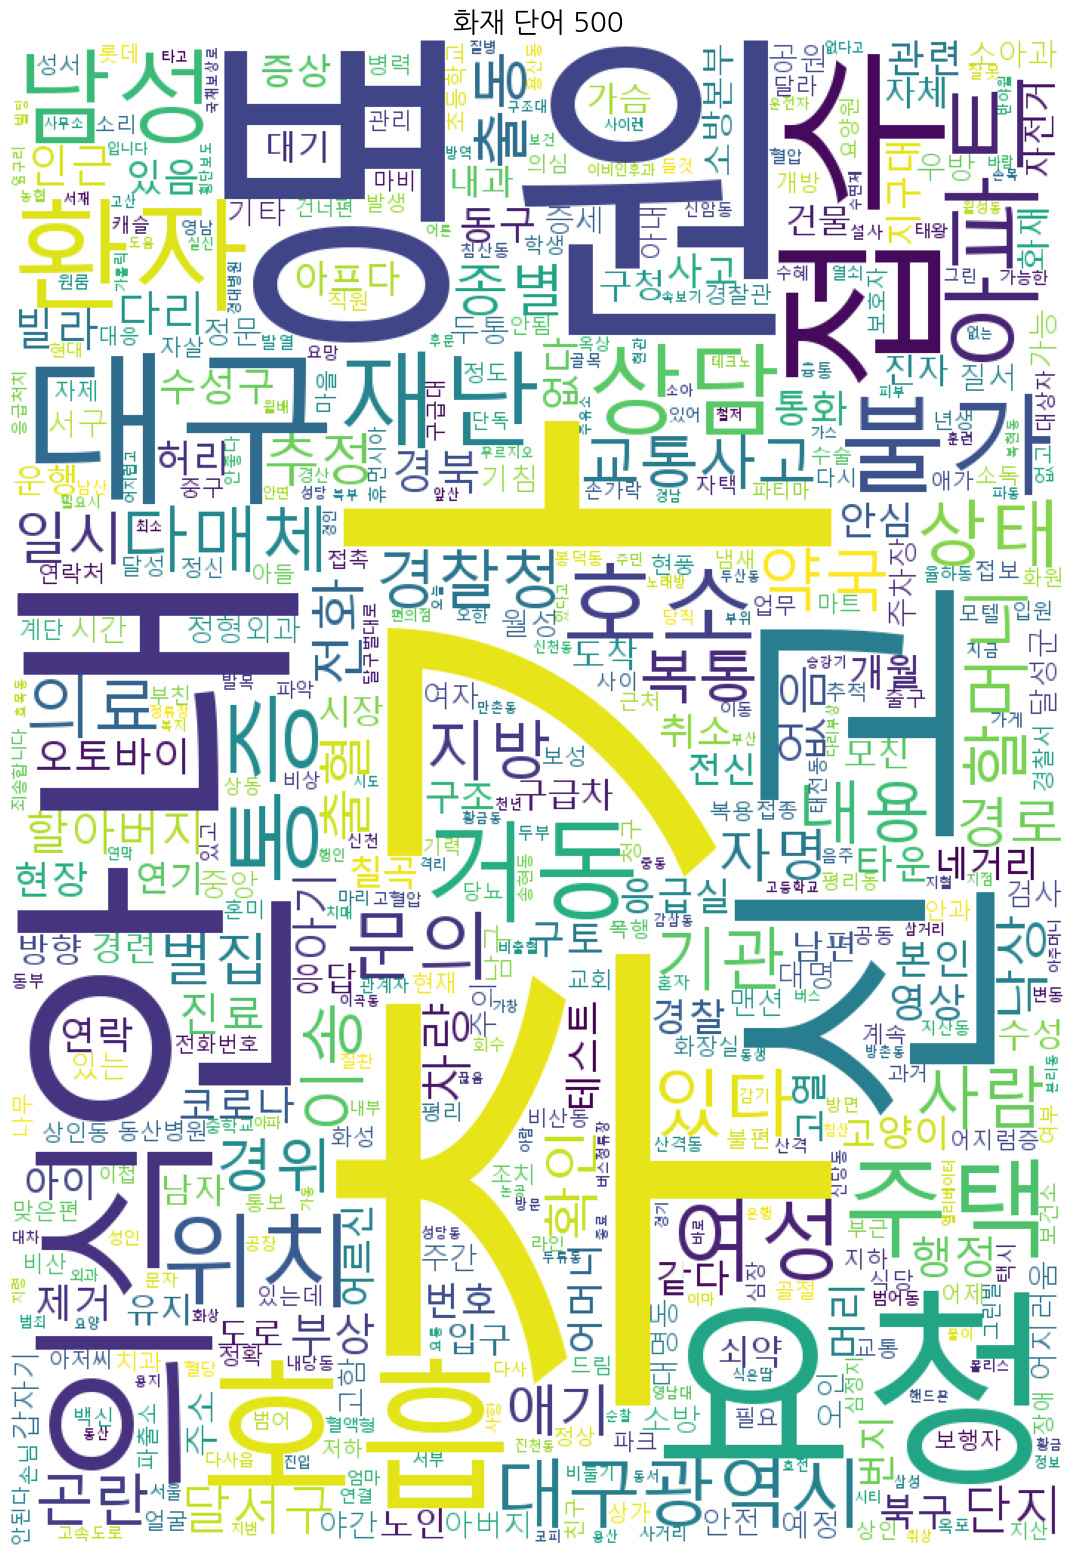

In [9]:
word_freq = []
word_pgr = []
doc_cnt = len(fire)
dtm_mat = make_dtm(fire, stopwords = ['구급','센터','상황','병원','추가','안내'])
plt.figure( figsize = (20, 20),dpi=100 )
plt.rc('font', family='NanumGothic')
plt.imshow(make_wordcloud(dtm_mat, width = 700, height = 1000))
plt.axis("off")
# plt.savefig(main_path + "/results/{}/{}_wordcloud.png".format(f_name ,year), bbox_inches='tight')
plt.title("화재 단어 500",fontsize=20)
plt.show()
plt.close()

In [10]:
word2 =dtm_mat.sum().sort_values(ascending=False)
word2.head(50)

추가       276886
병원       262839
안내       226731
신고       200843
요청       177449
의식       143263
접수       126041
대구       104166
호흡       102954
환자       101707
거동        84680
불가        82743
주택        78757
재난        75646
남성        74777
아파트       71360
통증        69370
상담        68686
위치        68190
호소        68161
여성        65642
대구광역시     63143
문의        60170
상태        59257
있다        58202
다매체       56731
의료        52778
내용        52284
할머니       51846
기관        50288
약국        50103
사람        49266
이송        48993
경찰청       45210
지방        45191
교통사고      44322
복통        44191
출동        44132
경위        43926
곤란        42282
확인        40476
일시        40168
종별        40043
추정        39247
자명        38622
벌집        38253
경로        35189
전화        35021
애기        34498
낙상        34199
dtype: int64

C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


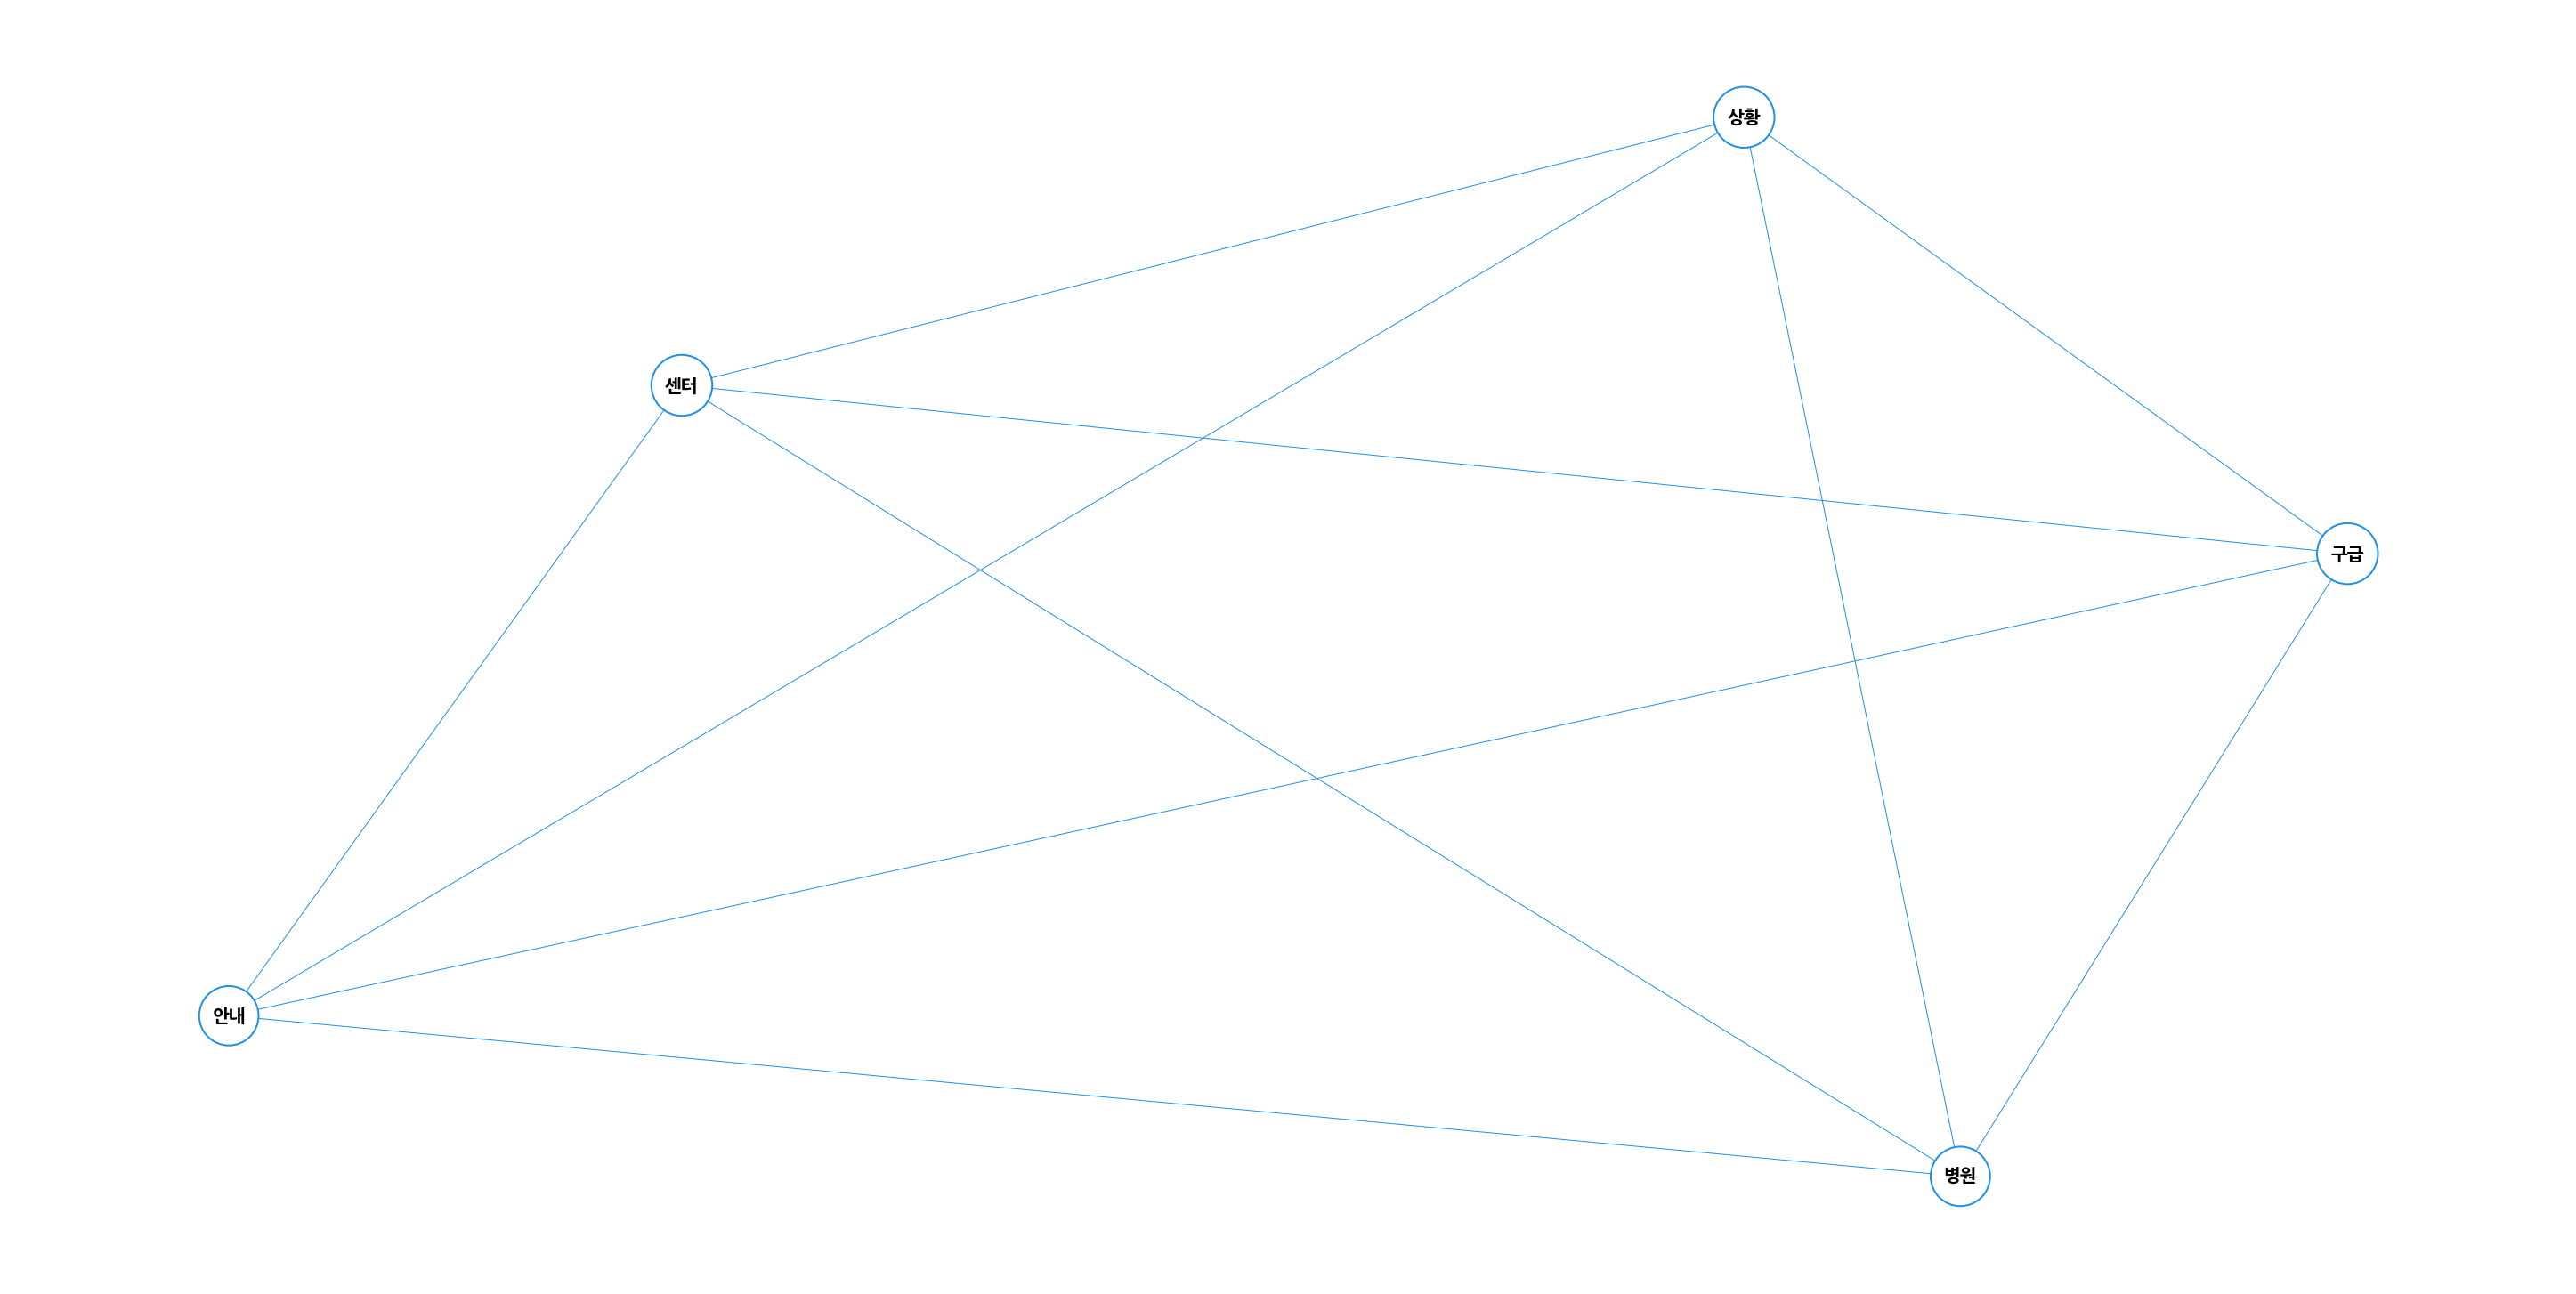

In [ ]:
### 단어빈도 및 네트워크 분석 ###
word_freq = []
word_pgr = []

doc_cnt = len(fire)
dtm_mat = make_dtm(fire,min_df = 70, stopwords = ["추가","아아"])
word_divide_doc = pd.DataFrame(pd.Series(dtm_mat.sum(axis = 0), name = "freq"))
word_divide_doc['idf'] = pd.Series(dtm_mat.sum(axis = 0), name = "freq") / doc_cnt
word_freq.append(word_divide_doc)
asso_rules = analy_asso(dtm_mat,support= 0.03, confidence = 0.1)
plt.figure( figsize = (40, 20) )
make_network(asso_rules, font_size = 20,eps = 1, figure = True)
plt.axis("off")
plt.show()
# plt.savefig(main_path + "/results/{}/{}_wordnetwork.png".format(f_name, year), bbox_inches = "tight")
plt.close()

In [12]:
df_non_fire=pd.DataFrame(non_fire)
df_non_fire

,0
0,경보기 오작동
1,화재경보기 화재 징후 없음 경산 경북 이첩
2,범어 번지 미술 학원 경보기 오작동
3,현대 바이오 경보기 오작동 추정 확인
4,동천동 칠곡 화성 타운 화재경보기 작동
...,...
26914,속보기 골로 건물
26915,평리동 한마음 노래방 화재경보기 린다 화재 징후 없다
26916,공단로 번지 지하 경보기 린다 화재 징후 없음
26917,화재경보기 배터리 교체 맨트


In [42]:
import os
# os.chdir("C:/seongwoo/script")
import pandas as pd
import pickle
# from minwon_func import *
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from wordcloud import WordCloud
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx
import math
import matplotlib.pyplot as plt
import gensim.corpora as corpora
from gensim import models
from matplotlib import font_manager,rc
import matplotlib
import matplotlib.pyplot as plt
 

font_path=r"C:\Windows\Fonts\malgun.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
matplotlib.rc('font',family=font_name)
 
# mac_path = "/Users/seongwoo/OneDrive/2020_하반기/코로나민원분석_시민소통과"
# win_path = "C:/seongwoo"
# main_path = win_path

####################################################################################
# with open(main_path + "/results/df_non_fire_1215.p", "rb") as f:    
#     df_non_fire = pickle.load(f)

# stopwords = pd.read_csv(main_path + "/dictionary/stopword_dic.csv",
    # encoding = 'cp949', header = None)[0].tolist()
stopwords = pd.read_csv('stopword_dic.csv',encoding = 'cp949', header = None)[0].tolist()

topic_list = [5, 7, 9, 11, 13, 15]
chunk_list = [5000, 7000, 10000]
pass_list = [10]
    
grid_mat  = []
for tp in topic_list:
    for cl in chunk_list:
        for pl in pass_list:
            grid_mat.append((tp, cl, pl))
    
for keywords in [(df_non_fire[0], "konlpy")]:   
        
    texts = keywords[0]
    bigram = models.Phrases(texts, min_count = 10)
    trigram = models.Phrases(bigram[texts])

    bigram_mod = models.phrases.Phraser(bigram)
    trigram_mod = models.phrases.Phraser(trigram)

    non_stopwords = remove_stopwords(texts, stopwords)
    non_stopwords_bigram = [bigram_mod[doc] for doc in non_stopwords]
    non_stopwords_trigram = [trigram_mod[bigram_mod[doc]] for doc in non_stopwords]
    
    id2word_bigram = corpora.Dictionary(non_stopwords_bigram)
    id2word_trigram = corpora.Dictionary(non_stopwords_trigram)
    
    id2word_bigram.filter_extremes(no_below= 10, no_above=1, keep_n=100000)
    id2word_trigram.filter_extremes(no_below= 10, no_above=1, keep_n=100000)
    
    for ngrams in [(non_stopwords_bigram, "bigram"),(non_stopwords_trigram, "trigram")]:
        
        if ngrams[1] =="bigram": 
            id2word = id2word_bigram
        else:
            id2word = id2word_trigram

        corpus = [id2word.doc2bow(text) for text in ngrams[0]] ##corpus 생성(tf)
        tfidf_res = models.TfidfModel(corpus)  ## tfidf 가중치로 변경
        corpus_tfidf = tfidf_res[corpus] ##corpus 생성(tfidf)
            
        for weighting in [(corpus, "wf"),(corpus_tfidf, "tfidf")]:  
            print("{} {} {} processing...".format(keywords[1], ngrams[1], weighting[1]))      
        
            for n_topic, n_chunk, n_passes in grid_mat:
                print("topic : {} chunk : {}  pass : {}".format(n_topic, n_chunk, n_passes))
#실행 문제 X
                fin_corpus, fin_model, fin_id2word = run_lda(corpus = weighting[0],
                                                                id2word = id2word,
                                                                num_topics = n_topic,
                                                                num_chunk= n_chunk,
                                                                num_passes= n_passes,
                                                                test = True)
# #변경>
#                 fin_corpus, fin_model, fin_id2word = run_lda(texts,n_topic)
        
                coherencemodel = CoherenceModel(model=fin_model, 
                                                corpus = fin_corpus, 
                                                dictionary=fin_id2word, 
                                                coherence='u_mass')
                
                perplexitymodel = fin_model.log_perplexity(fin_corpus)

                with open("results/topic/topic_gridsearch_res.txt", "a") as f:
                    f.write("tokenizer : {} ngrams : {} weighting : {}\
                                topic : {} chunk : {} pass : {}\
                               coh : {} perp : {}\n".format(keywords[1], ngrams[1], weighting[1], 
                                                       n_topic, n_chunk, n_passes, coherencemodel.get_coherence(),perplexitymodel))
                
                topic_words = []
                for tp in range(n_topic):
                    topic_words.append(find_topic_terms(fin_model, tp, topn=100))
                fin_topic_words = pd.concat(topic_words, axis=1)
                fin_topic_words.to_csv("results/topic/topic_{}_{}_{}_{}_{}_{}.csv".format(keywords[1], ngrams[1], weighting[1], 
                                                                                                       n_topic, n_chunk, n_passes) , encoding = "cp949")
                doc_topic, doc_topic_prob = find_doc_topic(fin_model, fin_corpus)
        
                df_non_fire["topic"] = doc_topic
                df_non_fire["topic_prob"] = doc_topic_prob
                df_non_fire.to_csv("results/topic/df_non_fire_{}_{}_{}_{}_{}_{}.csv".format(keywords[1], ngrams[1], weighting[1], 
                                n_topic, n_chunk, n_passes) , encoding = "cp949")
                
                for topic in range(n_topic):
                    print("topic number : {}".format(topic))
                    try: 
                        topic1_dtm = make_dtm(df_non_fire[df_non_fire["topic"] == topic].tit_cont)      
                    except: 
                        print("{} topic doesn't exist".format(topic))
                        
                        with open("results/topic/topic_notexist_list.txt", "a") as f:
                            f.write("tokenizer : {} ngrams : {} weighting : {}\
                                    topic : {} / {} chunk : {} pass : {}\n".format(keywords[1], ngrams[1], weighting[1], 
                                                           topic, n_topic, n_chunk, n_passes))
                        pass
                    else:
                        topic1_dtm.sum(axis = 0).sort_values(ascending = False).to_csv(
                                 "results/topic/keyword_{}_{}_{}_{}_{}_{}_{}.csv".format(keywords[1], ngrams[1], weighting[1], 
                                                                                                        n_topic, topic, n_chunk, n_passes) , encoding = "cp949")
                        
                        plt.figure(figsize=(20, 20))
                        
                        try:
                            plt.imshow(make_wordcloud(topic1_dtm))
                        except:
                            pass
                        else:
                            plt.savefig( "results/topic/wc_{}_{}_{}_{}_{}_{}_{}.png".format(keywords[1], ngrams[1], weighting[1], 
                                                                                                        n_topic, topic, n_chunk, n_passes))
                     





konlpy bigram wf processing...
topic : 5 chunk : 5000  pass : 10


TypeError: run_lda() got an unexpected keyword argument 'corpus'

In [39]:
fin_model

In [40]:
fin_id2word

### Word2vec(CBOW)
CountVectorizer Vectorizing  
TF-IDF Vectorizing



In [89]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

sentences = []
for sen in sents:
    sentences.append(sen.split())

In [90]:
# 파라미터
num_features = 300
min_word_count = 40
num_workers = 4
context = 10
downsampling = 1e-3 # 0.001

In [ ]:
from gensim.models import word2vec
print("Training model ....")
model = word2vec.Word2Vec(sentences, workers=num_workers, size=num_features, min_count=min_word_count, window=context, sample=downsampling)

In [92]:
tmp1 = model.wv.most_similar("속보")
tmp2= model.wv.most_similar("경보")
print(f'속보\n: {tmp1} \n')
print(f'경보\n: {tmp2} \n')

2022-01-24 13:11:21,403 : INFO : precomputing L2-norms of word weight vectors


속보
: [('자동', 0.8564385175704956), ('산업', 0.8405659794807434), ('주식회사', 0.826057493686676), ('한국', 0.8245533108711243), ('요양원', 0.8144120573997498), ('밸리', 0.8116074800491333), ('단대', 0.8028140068054199), ('테크', 0.7947039604187012), ('국가', 0.7946703433990479), ('공사', 0.7895727753639221)] 

경보
: [('방송', 0.8197112083435059), ('계속', 0.7894790172576904), ('소리', 0.7838154435157776), ('다매체', 0.7832159996032715), ('있는데', 0.7672750949859619), ('신고', 0.7647739052772522), ('인근', 0.7597019672393799), ('대피', 0.7518261075019836), ('일반', 0.7481555938720703), ('옆집', 0.7469539642333984)] 

